In [8]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
329682,0,2011559475,Tue Jun 02 19:12:34 PDT 2009,NO_QUERY,Diosanina,Burnt my fingers curling my hair.... owie
1021404,4,1882563590,Fri May 22 07:05:48 PDT 2009,NO_QUERY,twitch,@karolijn we had a rule in a regular IRC room ...
920076,4,1753921827,Sun May 10 04:08:24 PDT 2009,NO_QUERY,MMR04,@itssquish Im great! How are you? Im dying to...
1560221,4,2186293600,Mon Jun 15 18:37:57 PDT 2009,NO_QUERY,erinashleyJBfan,"@paulinhakemmer yepp i live in canada, brazil..."
519364,0,2191778595,Tue Jun 16 05:57:19 PDT 2009,NO_QUERY,TheClimb_x,Today it is boring.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
np.sum(df.isnull().any(axis=1))

0

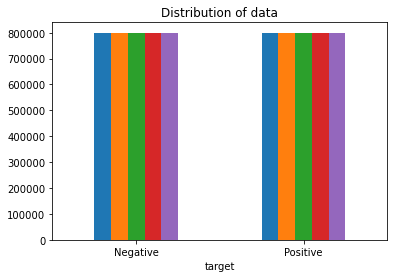

In [12]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

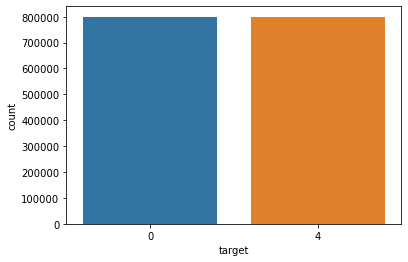

In [13]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [14]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)
data['target'].unique()


<ipython-input-14-77e6b04aebe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


array([0, 1], dtype=int64)

In [15]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [16]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [17]:
dataset = pd.concat([data_pos, data_neg])
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [18]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [19]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [22]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [23]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [24]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [19]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [21]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vemul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [25]:
X=data.text
y=data.target

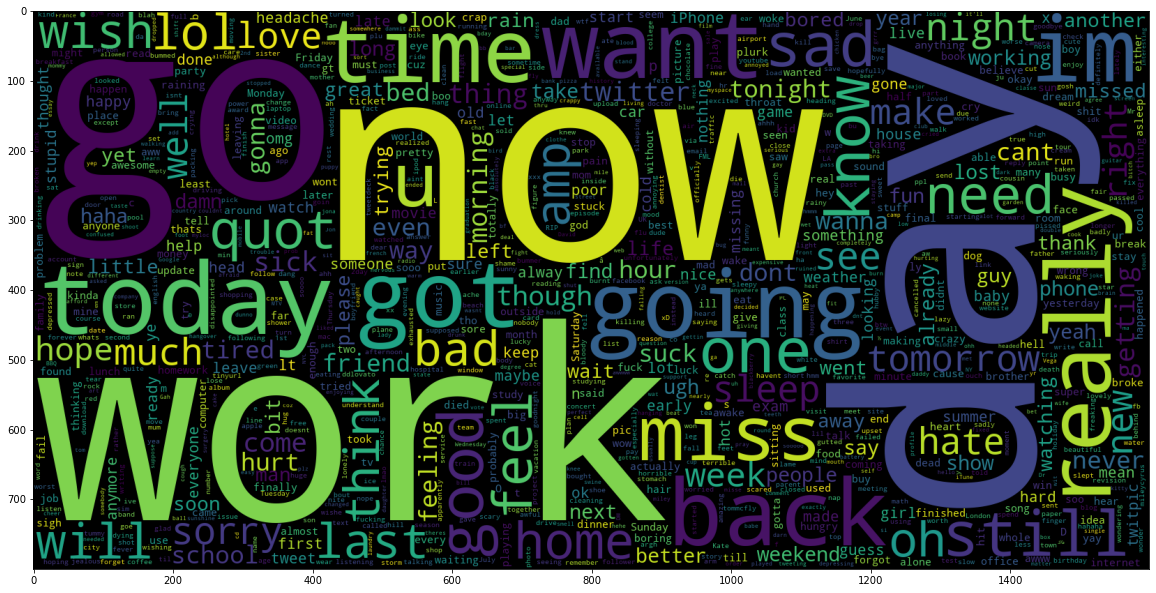

In [26]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

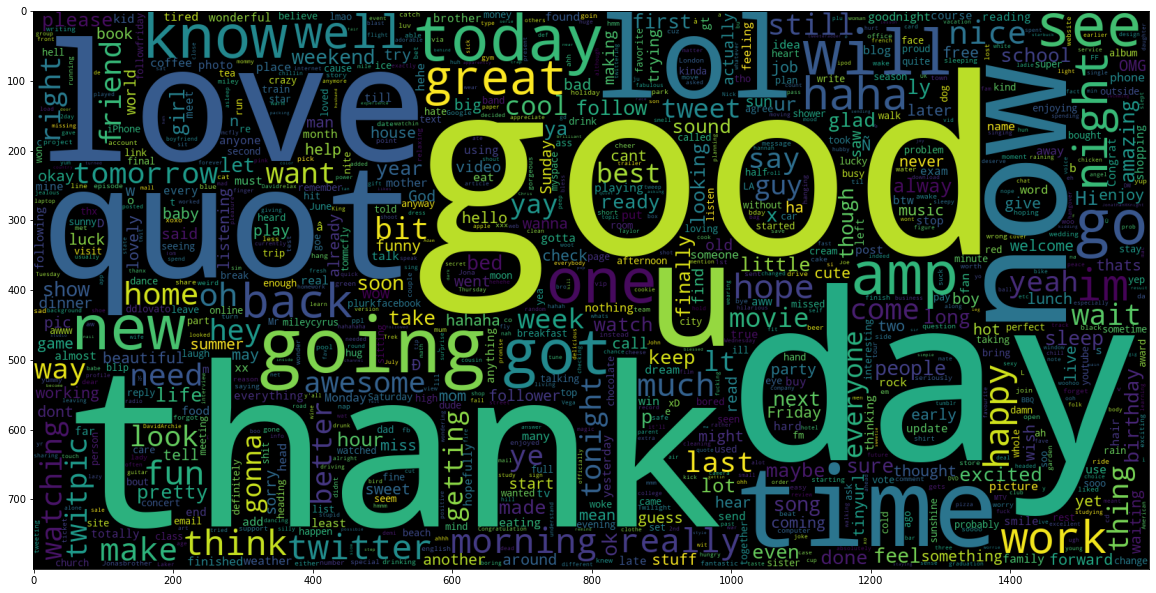

In [27]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)
print(X_train.head(5))

177690     @PanicCrew still no michigan shows    where's ...
270490     @rebekahnew I want to see your phone!!!!!! Sol...
272624     @akayoungin ohkohk, i just booked i put JUNE 3...
1378251    @austinhurst I hear it's amazing. Pulls no pun...
825497         Oh Ron White....  Time for bed now, methinks.
Name: text, dtype: object


In [155]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [156]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [157]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

[1 1 1 ... 1 0 0]


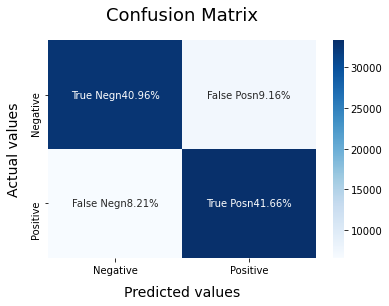

In [158]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)
print(y_pred3)

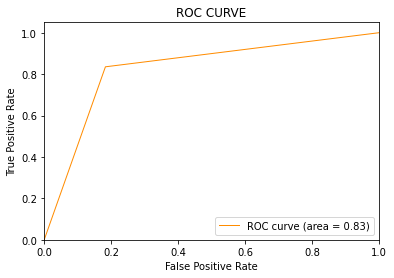

In [159]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [181]:
COLUMNS=['text','target']
df1 = pd.read_csv('tweets.csv', encoding="ISO-8859-1", names=COLUMNS)
df1.head(5)

,text,target
0,"A96 A90 Aberdeen - A92 Aberdeen - Closure, All...",NaN
1,"G'night, that's me signing off. We'll be back ...",NaN
2,"A1 - Tyne Bridge - Weather, All lanes restrict...",NaN
3,"Clackmannanshire - Weather, Drivers in Clackma...",NaN
4,"West Lothian - Weather, Drivers in West Lothia...",NaN


In [182]:
df1['text']=df1['text'].str.lower()
df1['text'].tail()

48    it's also advising against all travel to the c...
49    russia has more than 100-thousand soldiers at ...
50    rt @bbcscotweather: the weekend weather foreca...
51    rt @transcotland: #a96 #auchmill road: there w...
52    â surface waterâ \n    \nðincreased stopp...
Name: text, dtype: object

In [183]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [184]:
def getalpha(data):
    return re.sub('[^a-z\s]+', '', data)
df1['text'] = df1['text'].apply(lambda x: getalpha(x))

#def cleaning_numbers(data):
#    return re.sub('[0-9]+', '', data)
# df1['text'] = df1['text'].apply(lambda x: cleaning_numbers(x))
# df1['text'].tail()

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df1['text'] = df1['text'].apply(lambda text: cleaning_stopwords(text))
df1['text'].head()

0    aberdeen aberdeen closure lanes closed westbou...
1    gnight thats signing off well back tomorrow ht...
2    tyne bridge weather lanes restricted direction...
3    clackmannanshire weather drivers clackmannansh...
4    west lothian weather drivers west lothian advi...
Name: text, dtype: object

In [185]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df1['text']= df1['text'].apply(lambda x: cleaning_punctuations(x))
df1['text'].head()

0    aberdeen aberdeen closure lanes closed westbou...
1    gnight thats signing off well back tomorrow ht...
2    tyne bridge weather lanes restricted direction...
3    clackmannanshire weather drivers clackmannansh...
4    west lothian weather drivers west lothian advi...
Name: text, dtype: object

In [186]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df1['text'] = df1['text'].apply(lambda x: cleaning_repeating_char(x))
df1['text'].tail()

48                 also advising against travel country
49    russia thousand soldiers border but denies pla...
50    rt bbcscotweather weekend weather forecast chr...
51    rt transcotland auchmill road closure eastboun...
52    surface water increased stopping distances awa...
Name: text, dtype: object

In [187]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df1['text'] = df1['text'].apply(lambda x: cleaning_URLs(x))
df1['text'].head()

0    aberdeen aberdeen closure lanes closed westbou...
1    gnight thats signing off well back tomorrow ht...
2    tyne bridge weather lanes restricted direction...
3    clackmannanshire weather drivers clackmannansh...
4    west lothian weather drivers west lothian advi...
Name: text, dtype: object

In [188]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df1['text']= df1['text'].apply(lambda x: stemming_on_text(x))
df1['text'].head()

0    aberdeen aberdeen closure lanes closed westbou...
1    gnight thats signing off well back tomorrow ht...
2    tyne bridge weather lanes restricted direction...
3    clackmannanshire weather drivers clackmannansh...
4    west lothian weather drivers west lothian advi...
Name: text, dtype: object

In [189]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df1['text'] = df1['text'].apply(lambda x: lemmatizer_on_text(x))
df1['text'].head()

0    aberdeen aberdeen closure lanes closed westbou...
1    gnight thats signing off well back tomorrow ht...
2    tyne bridge weather lanes restricted direction...
3    clackmannanshire weather drivers clackmannansh...
4    west lothian weather drivers west lothian advi...
Name: text, dtype: object

In [191]:
display(df1['text'])
df1  = vectoriser.transform(df1)
y_pred4 = LRmodel.predict(df1)
print(y_pred4)

0     aberdeen aberdeen closure lanes closed westbou...
1     gnight thats signing off well back tomorrow ht...
2     tyne bridge weather lanes restricted direction...
3     clackmannanshire weather drivers clackmannansh...
4     west lothian weather drivers west lothian advi...
5     falkirk weather drivers falkirk advised use ca...
6     stirling weather drivers stirling advised use ...
7     got somewhere need but unsure roads check live...
8     south lanarkshire weather drivers south lanark...
9     north lanarkshire weather drivers north lanark...
10    call samaritans complete confidence free need ...
11    rt networkrailscot weve taken decision close f...
12    uk prime minister police investigation breakin...
13    aberdeen aberdeen closure lanes closed westbou...
14    b crosshands accident lanes restricted directi...
15    issues route today listen tsradio make journey...
16    j w e plantation closure lanes closed eastboun...
17    ever one stations need information assista

[1 1]
